In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = "C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\spotify_songs_clean.xlsx"  
xls = pd.ExcelFile(file_path)
df = xls.parse("Sheet1")

In [3]:
# on enlève les lignes ou les lyrics sont trop courts
df = df[df['lyrics'].str.len() > 15]
df.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\spotify_songs_clean.xlsx", index=False)

In [4]:
# On va créer des sets avec les artistes, les genres de musique et les sous genres

set_artists = set(df["track_artist"])
set_genres = set(df["playlist_genre"])
set_subgenres = set(df["playlist_subgenre"])
print("Nombre d'artistes uniques : ", len(set_artists))
print("Nombre de genres uniques : ", len(set_genres))
print("Nombre de sous-genres uniques : ", len(set_subgenres))

#on créer un xlsx avec les artistes, genres et sous-genres
df_artists = pd.DataFrame(set_artists, columns=["track_artist"])
df_genres = pd.DataFrame(set_genres, columns=["playlist_genre"])
df_subgenres = pd.DataFrame(set_subgenres, columns=["playlist_subgenre"])
df_artists.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\artists.xlsx", index=False)
df_genres.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\genres.xlsx", index=False)
df_subgenres.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\subgenres.xlsx", index=False)


Nombre d'artistes uniques :  5927
Nombre de genres uniques :  6
Nombre de sous-genres uniques :  24


In [ ]:
import musicbrainzngs

musicbrainzngs.set_useragent("TrouverOrginieGeos", "0.1", "elouan.vuichard@gmail.com")

#test requête musicbrainz pr voir les infos sur un artiste
try:
    result = musicbrainzngs.browse_artists(includes=
    artist = result['artist-list'][0]
    for key, value in artist.items():
        print(f"{key}: {value}")
    print(artist['name'])
    print(artist['country'])
except musicbrainzngs.WebServiceError as e:
    print(f"Web service error occurred: {e}")

#parfait

TypeError: browse_artists() got an unexpected keyword argument 'artist'

In [78]:
def clean_string(string):
    string = string.replace("&", "and")
    string = string.replace("'", "")
    string = string.replace("ó", "o")
    string = string.replace("é", "e")
    string = string.replace("è", "e")
    string = string.replace("ç", "c")
    string = string.replace("à", "a")
    string = string.replace(" ","")
    string = string.replace("-", "")
    string = string.replace("_", "")
    string = string.strip()
    return string.lower()

def get_country_and_gender(artist_name):
    limite = 5
    try:
        result = musicbrainzngs.search_artists(artist=artist_name, limit=limite)
        if not result['artist-list']:
            print("Aucun artiste trouvé pour : ", artist_name)
            return "Unknown", "Unknown"
        
        artist = None
        for i in range(len(result['artist-list'])):
            if clean_string(artist_name) == clean_string(result['artist-list'][i]['name']):
                artist = result['artist-list'][i]
                break

        if not artist:
            noms_trouves = ", ".join([a['name'] for a in result['artist-list']])
            print("Aucun artiste correspondant trouvé pour : ", artist_name, 
                  ". Noms trouvés : ", noms_trouves)
            return "Unknown", "Unknown"
        
        pays = get_pays(artist)
        genre = get_genre(artist)
        return pays,genre
    
    except musicbrainzngs.WebServiceError as e:
        print(f"Web service error occurred: {e}")
        return None

def get_genre(artist):
    if 'type' in artist:
        if artist['type'] == 'Person' and 'gender' in artist:
            genre = artist['gender']
        else:
            genre = artist['type']
    else:
        genre = "Unknown"
    return genre

def get_pays(artist):
    if 'country' in artist:
        pays = artist['country']
    else:
        pays = "Unknown"
    return pays

In [ ]:
LIMITE = -1
# on créer deux nouvelles colonnes dans le df : pays et genre
file = "C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\artists.xlsx"
df_artists = pd.read_excel(file)
df_artists['pays'] = None
df_artists['genre'] = None

for index, row in df_artists.iterrows():
    artist_name = row['track_artist']
    pays, genre = get_country_and_gender(str(artist_name))
    if pays is not None and genre is not None:
        df_artists.at[index, 'pays'] = pays
        df_artists.at[index, 'genre'] = genre
    else:
        print(f"Could not retrieve data for artist: {artist_name}")
    if index >= LIMITE and LIMITE != -1:
        print("Limite de " + str(LIMITE) + " atteinte")
        break

Aucun artiste trouvé pour :  Yady
Aucun artiste correspondant trouvé pour :  Frans . Noms trouvés :  Frans Bauer, Frans Brüggen, Frans Halsema, Frans Duijts, Frans van Steijn
Aucun artiste correspondant trouvé pour :  Lil West . Noms trouvés :  Lil Wayne, Lil B, Lil Uzi Vert, Go West, Lil Durk
Aucun artiste correspondant trouvé pour :  Art Aguilera . Noms trouvés :  Christina Aguilera, Art Tatum, Art Pepper, Art Farmer, Art Blakey
Aucun artiste correspondant trouvé pour :  Daniel Skye . Noms trouvés :  Daniel Barenboim, Daniel Pemberton, Daniel C. Holter, Emily Skye, Daniel Alexander
Aucun artiste correspondant trouvé pour :  August Roads . Noms trouvés :  August Zirner, August Burns Red, Roads, Roads, Christian August Vulpius
Aucun artiste correspondant trouvé pour :  Keys of Philadelphia . Noms trouvés :  Hot Club of Philadelphia, Chamber Symphony of Philadelphia, Chamber Orchestra of Philadelphia, Mendelssohn Club of Philadelphia, Soul Satisfiers Of Philadelphia
Aucun artiste corres

In [43]:
df_artists['pays'] = df_artists['pays'].fillna("Unknown")
df_artists['genre'] = df_artists['genre'].fillna("Unknown")
print("Nombre d'artistes sans pays : ", df_artists[df_artists['pays'] == "Unknown"].shape[0] , "/", df_artists.shape[0])
print("Nombre d'artistes sans genre : ", df_artists[df_artists['genre'] == "Unknown"].shape[0], "/", df_artists.shape[0])

# on enregistre le df avec les pays et genres

df_artists.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\artists_with_country_and_gender.xlsx", index=False)


Nombre d'artistes sans pays :  1765 / 5927
Nombre d'artistes sans genre :  867 / 5927


In [14]:
#pour obtenir la lise des pays et genres uniques avec leur effectif
df_artists[df_artists['genre'] == "other"] = "Other"
df_artists[df_artists['genre'] == "Character"] = "Person"

set_pays = set(df_artists["pays"])
list_effectif_pays = [len(df_artists[df_artists["pays"] == pays]) for pays in set_pays]
set_genres = set(df_artists["genre"])
list_effectif_genres = [len(df_artists[df_artists["genre"] == genre]) for genre in set_genres]
print("Nombre de pays uniques : ", len(set_pays))
print("Nombre de genres uniques : ", len(set_genres))
print("Liste des pays : ", ", ".join(set_pays))
print("Liste des genres : ", ", ".join(set_genres))

df_pays = pd.DataFrame(set_pays, columns=["pays"])
df_pays['effectif'] = list_effectif_pays
df_genres = pd.DataFrame(set_genres, columns=["genre"])
df_genres['effectif'] = list_effectif_genres
df_pays.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\pays.xlsx", index=False)
df_genres.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\genres.xlsx", index=False)

Nombre de pays uniques :  77
Nombre de genres uniques :  6
Liste des pays :  TN, NZ, NL, CN, JP, HU, MY, PA, PE, NG, ML, XK, MX, PL, RS, SN, IT, TT, SG, DK, US, JM, IN, VG, PS, Person, GB, KR, SK, HR, CA, CU, PH, CO, DO, AU, IS, MD, CH, RO, NO, AT, Other, LT, GR, VE, TH, ZM, CR, FR, PK, BR, SA, UY, GT, AR, IL, BE, CL, FI, PT, SE, GH, ID, PR, VC, DE, FO, KE, AG, IE, TR, GY, EE, ES, RU, ZA
Liste des genres :  non-binary, Person, Group, female, male, Other


In [93]:
import requests

API_KEY = '3b963f84450d502c78e1400235c8241c'
API_URL = 'http://ws.audioscrobbler.com/2.0/'

def lastfm_get_country_and_gender(artist_name):
    params = {
        'method': 'artist.getinfo',
        'artist': artist_name,
        'api_key': API_KEY,
        'format': 'json'
    }
    
    response = requests.get(API_URL, params=params)
    
    if response.status_code == 200:
        data = response.json()
        print("Artist : ", data['artist']['name'], " tags : ", data['artist']['tags']['tag'][0]['name'] if 'tags' in data['artist'] and 'tag' in data['artist']['tags'] and len(data['artist']['tags']['tag']) > 0 else "Unknown")
        if 'artist' in data and 'country' in data:
            print("Pays : ", data['artist']['country'])
            print("Genre : ", data['artist']['tags']['tag'][0]['name'] if 'tags' in data['artist'] and 'tag' in data['artist']['tags'] else "Unknown")

lastfm_get_country_and_gender("Christine and the Queens")
lastfm_get_country_and_gender("The Weeknd")
lastfm_get_country_and_gender("Daft Punk") 

Artist :  Christine and the Queens  tags :  french
Artist :  The Weeknd  tags :  rnb
Artist :  Daft Punk  tags :  electronic


In [95]:
# artistes sans pays et genre
unknown_artists = df_artists[(df_artists['pays'] == "Unknown") & (df_artists['genre'] == "Unknown")]
print("Nombre d'artistes sans pays ou genre : ", unknown_artists.shape[0], "/", df_artists.shape[0])

# on va refaire le code précédant sur unknown_artist mais en cleanant les noms des artistes avant de les envoyer à MusicBrainz
LIMITE = 40
i = 0
for index, row in unknown_artists.iterrows():
    artist_name = row['track_artist']
    lastfm_get_country_and_gender(str(artist_name))
    i += 1
    if i >= LIMITE and LIMITE != -1:
        print("Limite de " + str(LIMITE) + " atteinte")
        break



Nombre d'artistes sans pays ou genre :  859 / 5927
Artist :  Denine  tags :  freestyle
Artist :  Hoodcelebrityy  tags :  better than selena gomez
Artist :  Yady  tags :  Unknown
Artist :  Frans  tags :  Eurovision
Artist :  Lil West  tags :  Hip-Hop
Artist :  Art Aguilera  tags :  Unknown
Artist :  Daniel Skye  tags :  pop
Artist :  Nightro  tags :  Hip-Hop
Artist :  Califa Thugs  tags :  Chicano Rap
Artist :  August Roads  tags :  Unknown
Artist :  Keys of Philadelphia  tags :  Unknown
Artist :  Adam K  tags :  House
Artist :  (Sandy) Alex G  tags :  seen live
Artist :  Matt Moore  tags :  electronic
Artist :  The Sacados  tags :  pop
Artist :  Waxwane  tags :  Unknown
Artist :  SiXn  tags :  Unknown
Artist :  Miles Wesley  tags :  pop
Artist :  Youngjae  tags :  got7
Artist :  Ron SUNO  tags :  rap
Artist :  DJ Ross  tags :  dance
Artist :  King Harvest  tags :  classic rock
Artist :  Stackztootrill  tags :  Unknown
Artist :  Dan Hill  tags :  pop
Artist :  Lil Whigga  tags :  Unknow

In [10]:
#chargement du fichier avec les pays et genres
df_artists = pd.read_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\artists_with_country_and_gender.xlsx")
df_pays = pd.read_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\pays.xlsx")

country_region_map = {
    # European
    'HU': 'european', 'IS': 'european', 'FR': 'european', 'GB': 'european', 'GR': 'european',
    'NO': 'european', 'IT': 'european', 'LT': 'european', 'FO': 'european', 'BE': 'european',
    'FI': 'european', 'RU': 'european', 'MD': 'european', 'EE': 'european', 'RS': 'european',
    'PT': 'european', 'SK': 'european', 'RO': 'european', 'HR': 'european', 'IE': 'european',
    'SE': 'european', 'CH': 'european', 'NL': 'european', 'XK': 'european', 'DK': 'european',
    'DE': 'european', 'AT': 'european', 'ES': 'european', 'PL': 'european',

    # Asian
    'MY': 'asian', 'ID': 'asian', 'SG': 'asian', 'CN': 'asian', 'IN': 'asian',
    'KR': 'asian', 'JP': 'asian', 'IL': 'asian', 'TH': 'asian', 'PK': 'asian',
    'PH': 'asian', 'TR': 'asian',

    # African
    'ZM': 'african', 'NG': 'african', 'KE': 'african', 'ML': 'african', 'ZA': 'african',
    'GH': 'african', 'SN': 'african',

    # Arabic
    'SA': 'arabic', 'TN': 'arabic', 'PS': 'arabic',

    # North American
    'US': 'north-american', 'CA': 'north-american', 'MX': 'north-american',
    'PR': 'north-american', 'VG': 'north-american',

    # Latino / South American
    'AR': 'latino', 'VE': 'latino', 'CR': 'latino', 'CO': 'latino', 'PA': 'latino',
    'PE': 'latino', 'DO': 'latino', 'GT': 'latino', 'CL': 'latino', 'CU': 'latino',
    'UY': 'latino', 'BR': 'latino', 'GY': 'latino', 'JM': 'latino', 'TT': 'latino',
    'VC': 'latino', 'AG': 'latino',

    # Oceania
    'NZ': 'oceania', 'AU': 'oceania',
}

df_with_regions = df.copy()
print("Nombre de lignes dans le df : ", df_with_regions.shape[0])
# on utilise les infos sur les artistes pour croiser les données et remplir la colonne 'ethnie' dans le df

df_artists = df_artists[df_artists['pays'] != "Unknown"] # on retire les lignes pour lesquelles l'artiste provient d'un pays inconnu

df_with_regions = df_with_regions[df_with_regions['track_artist'].isin(df_artists['track_artist'])] # on ne garde que les lignes du df avec les artistes qui ont un pays renseigné
df_with_regions = df_with_regions.merge(df_artists[['track_artist', 'pays']], on='track_artist', how='left')
df_with_regions['ethnie'] = df_with_regions['pays'].map(country_region_map).fillna('other')
df_with_regions = df_with_regions.drop(columns=['pays'])  # on supprime la colonne 'pays' car on n'en a plus besoin

print("Nombre de lignes dans le df avec les régions : ", df_with_regions.shape[0])

#on affiche les premières lignes du df
print(df_with_regions.head())

# on enregistre le df avec les régions
df_with_regions.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\spotify_songs_with_regions.xlsx", index=False)


Nombre de lignes dans le df :  18146
Nombre de lignes dans le df avec les régions :  14627
                                          track_name     track_artist  \
0                                           Pangarap  Barbie's Cradle   
1                                             Poison   Bell Biv DeVoe   
2  Baby It's Cold Outside (feat. Christina Aguilera)      CeeLo Green   
3                                         Dumb Litty             KARD   
4                                            Soldier         James TW   

  language playlist_genre          ethnie   playlist_subgenre  \
0       tl           rock           asian        classic rock   
1       en            r&b  north-american      new jack swing   
2       en            r&b  north-american            neo soul   
3       en            pop           asian           dance pop   
4       en            r&b        european  urban contemporary   

                                              lyrics  
0  Minsan pa Nang ako'y 

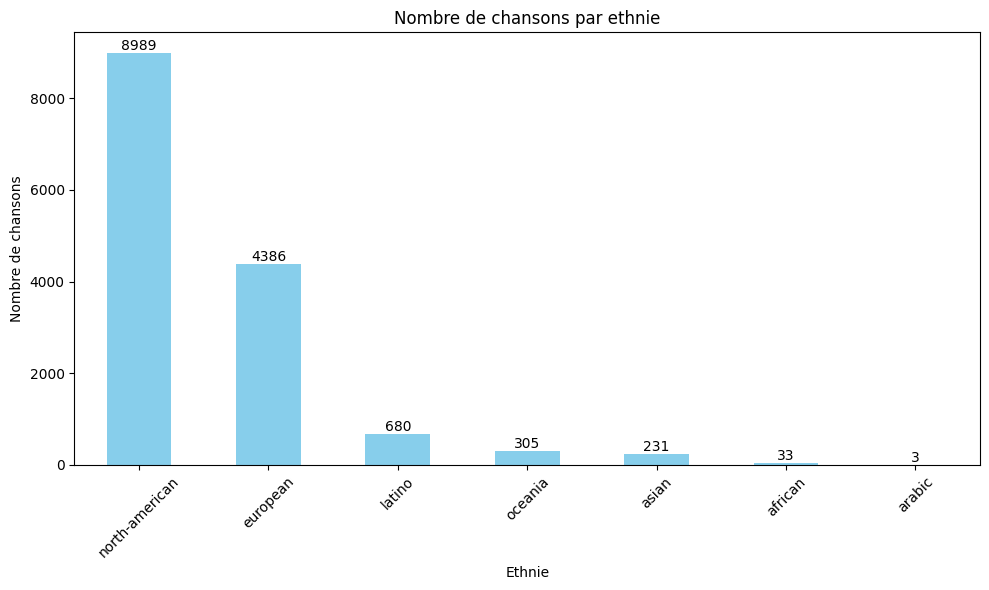

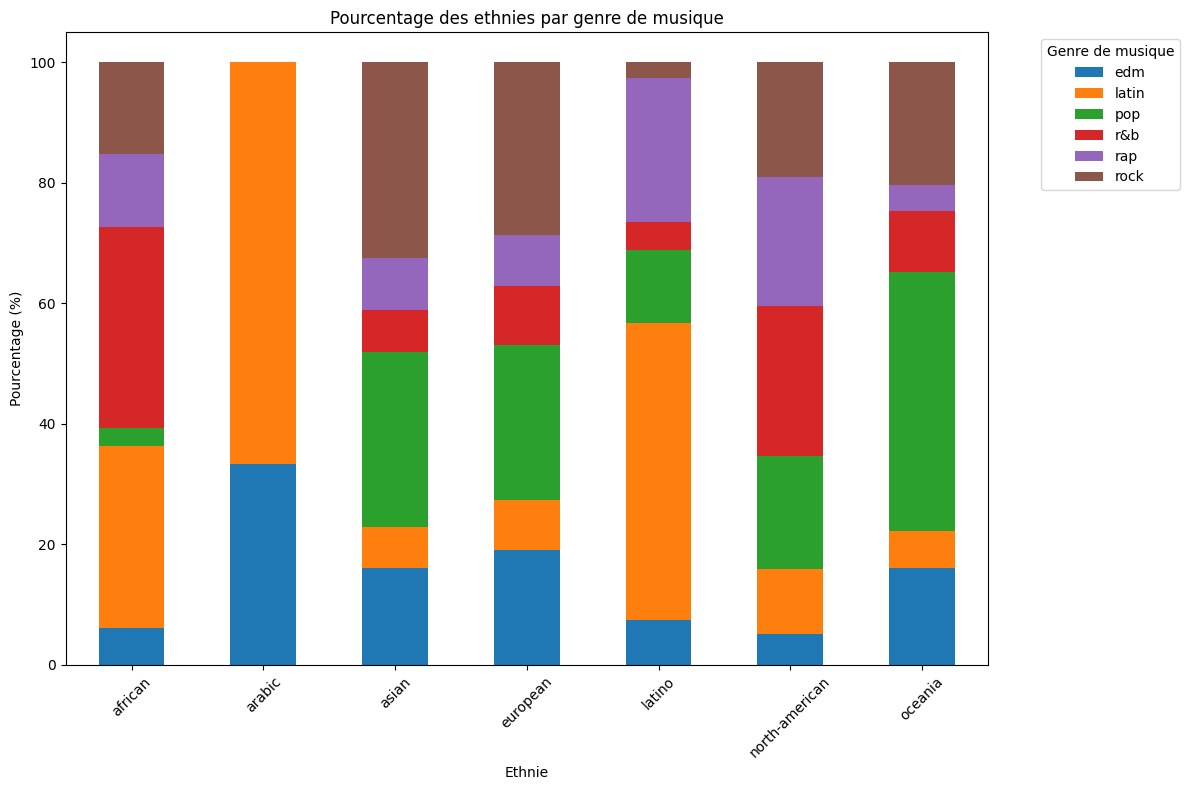

In [11]:
df_with_regions = pd.read_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\spotify_songs_with_regions.xlsx")

#faire un graphe pour afficher le nombre de chansons par ethnie puis les pourcentages des ethnies par genre de musique
import matplotlib.pyplot as plt
# Compter le nombre de chansons par ethnie
ethnie_counts = df_with_regions['ethnie'].value_counts()
# Créer un graphique à barres
plt.figure(figsize=(10, 6))
ethnie_counts.plot(kind='bar', color='skyblue')
plt.title('Nombre de chansons par ethnie')
plt.xlabel('Ethnie')
plt.ylabel('Nombre de chansons')
plt.xticks(rotation=45)
# afficher le nombre de chansons pour chaque ethnie au dessus de chaque barre
for index, value in enumerate(ethnie_counts):
    plt.text(index, value + 5, str(value), ha='center', va='bottom')
plt.tight_layout()
plt.savefig("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\nombre_chansons_par_ethnie.png")

# Calculer les pourcentages des ethnies par genre de musique
ethnie_genre_counts = df_with_regions.groupby(['ethnie', 'playlist_genre']).size().unstack(fill_value=0)
# Calculer les pourcentages
ethnie_genre_percentages = ethnie_genre_counts.div(ethnie_genre_counts.sum(axis=1), axis=0) * 100
# Créer un graphique à barres empilées
ethnie_genre_percentages.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Pourcentage des ethnies par genre de musique')
plt.xlabel('Ethnie')
plt.ylabel('Pourcentage (%)')
plt.legend(title='Genre de musique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\pourcentage_ethnies_par_genre.png")
# Afficher les graphiques
plt.show()

Nombre de lignes dans le df avec les régions :  14627
Nombre de lignes dans le df avec les régions et genres :  14601


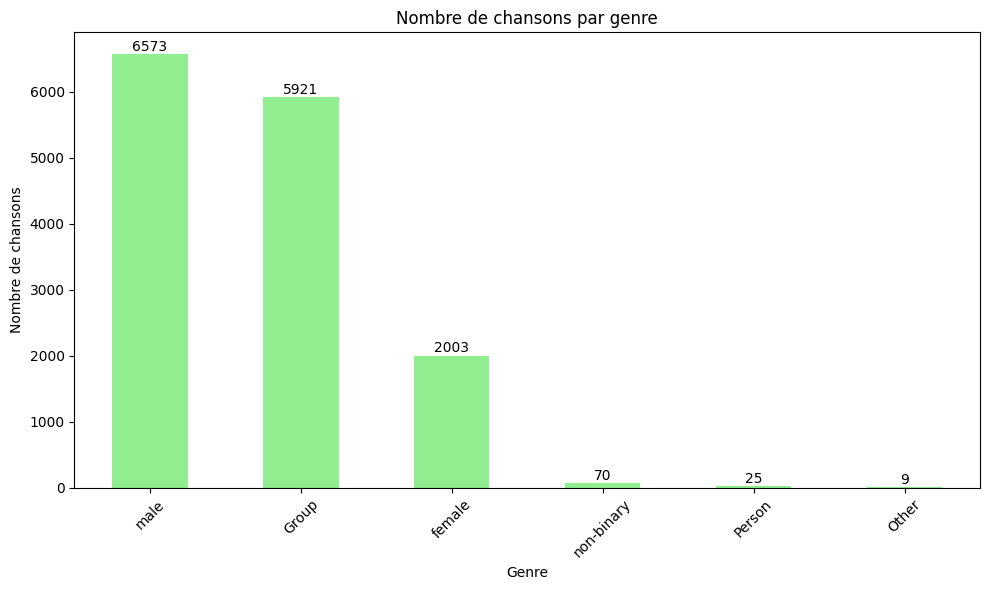

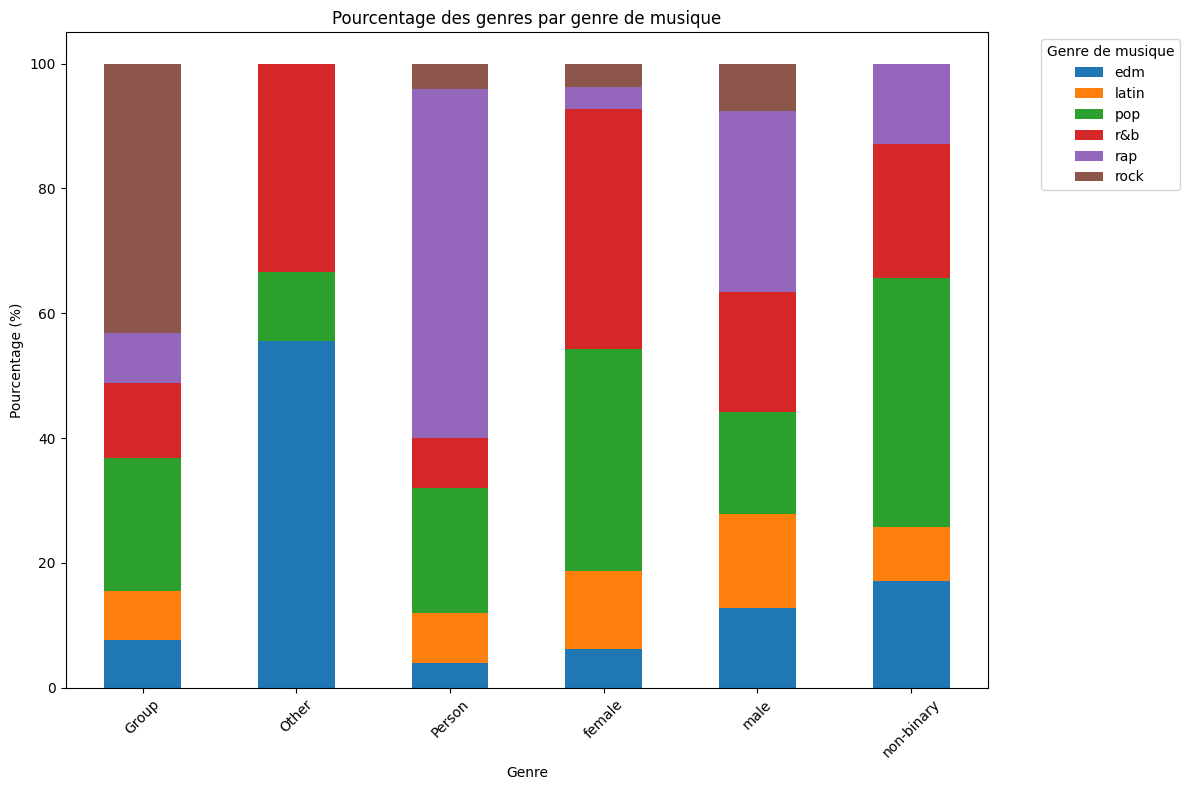

In [ ]:
# même chose pour les genres des artistes (sexe)
print("Nombre de lignes dans le df avec les régions : ", df_with_regions.shape[0])
df_artists = df_artists[df_artists['genre'] != "Unknown"]  # on retire les lignes pour lesquelles l'artiste a un genre inconnu

df_with_regions_and_gender = df_with_regions[df_with_regions['track_artist'].isin(df_artists['track_artist'])]  # on ne garde que les lignes du df avec les artistes qui ont un genre renseigné
df_with_regions_and_gender = df_with_regions_and_gender.merge(df_artists[['track_artist', 'genre']], on='track_artist', how='left') 

print("Nombre de lignes dans le df avec les régions et genres : ", df_with_regions_and_gender.shape[0])

df_with_regions_and_gender.to_excel("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\spotify_songs_with_regions_and_gender.xlsx", index=False)

# Compter le nombre de chansons par genre
genre_counts = df_with_regions_and_gender['genre'].value_counts()
# Créer un graphique à barres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='lightgreen')
plt.title('Nombre de chansons par genre')
plt.xlabel('Genre')
plt.ylabel('Nombre de chansons')
# afficher le nombre de chansons pour chaque genre au dessus de chaque barre
for index, value in enumerate(genre_counts):
    plt.text(index, value + 5, str(value), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\nombre_chansons_par_genre.png")

# Calculer les pourcentages des genres par genre (sexe)
genre_genre_counts = df_with_regions_and_gender.groupby(['genre', 'playlist_genre']).size().unstack(fill_value=0)
# Calculer les pourcentages
genre_genre_percentages = genre_genre_counts.div(genre_genre_counts.sum(axis=1), axis=0) * 100
# Créer un graphique à barres empilées
genre_genre_percentages.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Pourcentage des genres par genre de musique')
plt.xlabel('Genre')
plt.ylabel('Pourcentage (%)')
plt.legend(title='Genre de musique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("C:\\Users\\Elouan\\Documents\\Projet Biais LLM\\pourcentage_genres_par_genre.png")
# Afficher les graphiques
plt.show()